# Simulation de pont brownien et application au pricing d'options
On appelle pont brownien (sans précision) un processus dont la loi est celle du mouvement brownien standard conditionné par un retour en 0 au temps 1. On s’intéresse ici à la distribution du maximum sur [0, 1] d’un tel processus. 

### Plan : 
- Étude du maximum d'un mouvement brownien conditionné, approché par sélection de trajectoires. 
- Le pont brownien comme solution d'une équation différentielle stochastique, implémentation d'un schéma d'Euler
- Étude de $\mathbb{E}[U^2]$ où U est le maximum du pont brownien, méthode de Monte-Carlo et réduction de variance
- Application au pricing d'options

## I - Un brownien conditionné approché

**I-1)** Écriture d'une procédure qui construit des trajectoires de mouvement brownien sur $[0, 1]$ et qui retourne les réalisations qui arrivent au temps 1 dans l’intervalle $]−\epsilon, \epsilon[$.

In [2]:
# Imports
import math
import numpy as np
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, expon
from scipy.integrate import quad
import warnings

In [3]:
# Définition de la fonction qui génère notre mouvement brownien conditionné
def brownien_conditionne(epsilon, n_trajectoires, n_points):
    """
    Génère des trajectoires de mouvement brownien standard sur [0, 1] ainsi que des trajectoires de pont brownien (conditionné à revenir en 0 à t=1).

    Returns
    -------
    trajectoires_filtrees : np.ndarray
        Tableau (n_filtrees, n_points+1) des trajectoires filtrées.
    toutes_les_trajectoires : np.ndarray
        Tableau (n_trajectoires, n_points+1) de toutes les trajectoires simulées.
    """
    # Pas de temps
    dt = 1.0 / n_points  

    # Génération des trajectoires de mouvement brownien standard 
    increments = np.sqrt(dt) * np.random.normal(0, 1, (n_trajectoires, n_points))
    trajectoires = np.zeros((n_trajectoires, n_points + 1))
    trajectoires[:, 1:] = np.cumsum(increments, axis=1)

    # Filtrage
    mask = np.abs(trajectoires[:, -1]) <= epsilon
    trajectoires_filtrees = trajectoires[mask]

    return trajectoires_filtrees, trajectoires

**I-2)** Représentation de 5 trajectoires filtrées sur un même graphique, observation du nombre de trajectoires filtrées

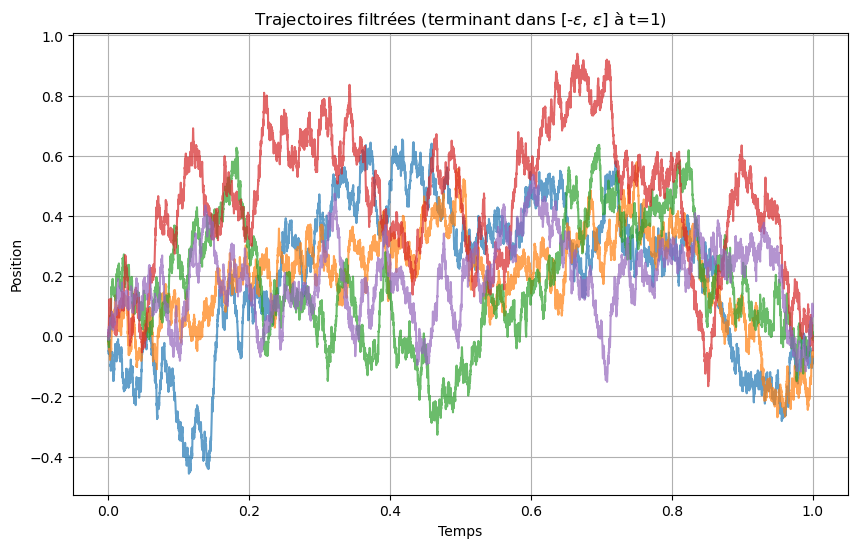

Nombre de trajectoires générées : 1000
Nombre de trajectoires filtrées pour epsilon = 0.1 : 93


In [12]:
# Paramètres
epsilon = 0.1
n_trajectoires = 1000
n_points = 10000

#Génération des trajectoires
trajectoires_filtrees, toutes_les_trajectoires = brownien_conditionne(epsilon, n_trajectoires, n_points)
# Gestion du cas où moins de 5 trajectoires passent le filtre
n_afficher = min(5, len(trajectoires_filtrees))

# Tracé
plt.figure(figsize=(10, 6))
for i in range(n_afficher): 
    plt.plot(np.linspace(0, 1, n_points + 1), trajectoires_filtrees[i], alpha=0.7)
plt.title("Trajectoires filtrées (terminant dans [-$\\epsilon$, $\\epsilon$] à t=1)")
plt.xlabel("Temps")
plt.ylabel("Position")
plt.grid(True)
plt.show()  

# Métriques
print(f"Nombre de trajectoires générées : {n_trajectoires}")
print(f"Nombre de trajectoires filtrées pour epsilon = {epsilon} : {len(trajectoires_filtrees)}")

Sur 1000 trajectoires, un peu moins d'une centaine est retenue avec un seuil de filtrage à 0.1. Cela pose la question de l'efficacité en fonction du seuil : plus nous allons diminuer epsilon, plus il faudra augmenter `n_trajectoires` pour obtenir suffisamment de trajectoires filtrées en sortie.

**I-3)** Mesure de l’efficacité de la méthode en fonction de $\epsilon$ en terme de pourcentage de trajectoires sélectionnées

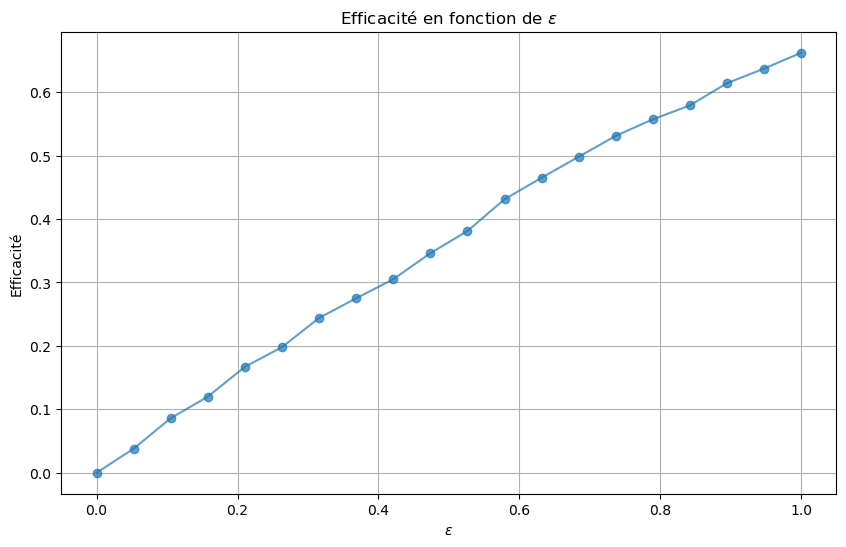

In [13]:
def courbe_efficacite(n_trajectoires, n_points): 
    #On simule une fois sans filtrer
    _, toutes_trajectoires = brownien_conditionne(1.0, n_trajectoires, n_points)
    #On récupère les valeurs finales 
    valeurs_finales = toutes_trajectoires[:, -1]

    liste_epsilon= np.linspace(0, 1, 20)
    liste_efficacite = [(np.abs(valeurs_finales) <= eps).mean() for eps in liste_epsilon]
    
    return liste_epsilon, np.array(liste_efficacite)

epsilons, efficacites = courbe_efficacite(n_trajectoires, n_points)

plt.figure(figsize=(10, 6))
plt.plot(epsilons, efficacites, marker='o', alpha=0.7)
plt.title("Efficacité en fonction de $\\epsilon$")
plt.xlabel("$\\epsilon$")
plt.ylabel("Efficacité")
plt.grid(True)
plt.show()

L'efficacité, mesurée en pourcentage du nombre de trajectoires retenue, est linéaire en fonction de epsilon.

On s'intéresse désormais à la distribution du maximum des trajectoires obtenues. Ce dernier existe (presque sûrement) car un pont brownien est un mouvement brownien conditionné, donc continu presque sûrement. Or toute fonction continue sur un compact (ici l'intervalle $[0,1]$) admet un maximum (et un minimum) atteint.

**I-4)** Écriture d'une procédure qui construit la fonction de répartition discrétisée du maximum des trajectoires obtenues et représentation graphique

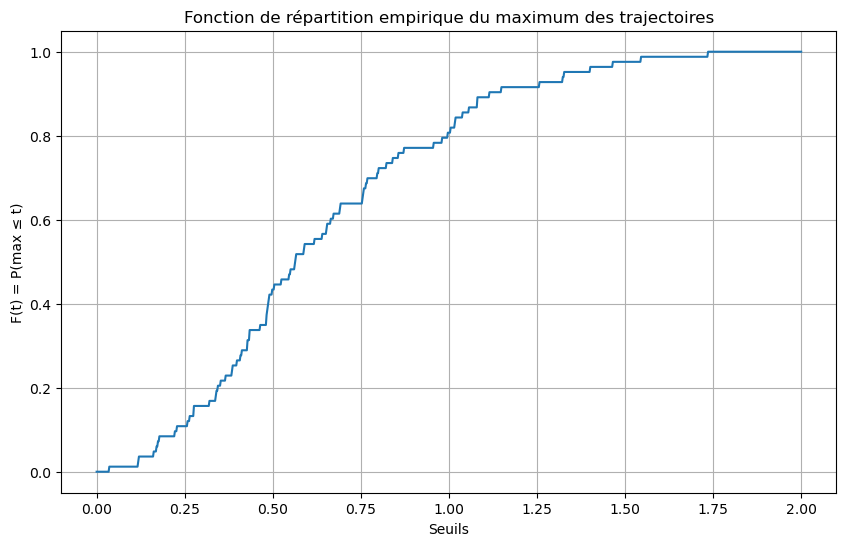

Le maximum sera inférieur à : 1.3273 avec une probabilité de 95%


In [18]:
# On cherche le maximum de chaque trajectoire filtrée
def calcul_max(trajectoires_filtrees):
    return np.array([np.max(traj) for traj in trajectoires_filtrees])

# On construit la fonction de répartition empirique du maximum des trajectoires
def cdf_empirique(maximums, seuils):
    # maximums : tableau numpy des maximums des trajectoires 
    # seuils : valeurs t pour lesquelles on calcule F(t) = P(max <= t)
    # Résultat : un vecteur F(t) avec la proportion correspondante pour chaque seuil
    maximums = np.asarray(maximums)
    seuils = np.asarray(seuils)

    # On compare une matrice colonne de taille n_traj à une matrice ligne de taille n_seuils :
    # On obtient une matrice booléenne, 1 ligne = un maximum, 1 colonne = un seuil
    cdf_vals = (maximums[:, None] <= seuils[None, :]).mean(axis=0)
    return cdf_vals

epsilon = 0.1

trajectoires_filtrees, _ = brownien_conditionne(epsilon, n_trajectoires, n_points)
maximums = calcul_max(trajectoires_filtrees)

# On considère 1000 seuils entre 0 et 2
liste_seuils = np.linspace(0, 2, 1000)
liste_valeurs = cdf_empirique(maximums, liste_seuils)

# Tracé
plt.figure(figsize=(10, 6))
plt.plot(liste_seuils, liste_valeurs)
plt.title("Fonction de répartition empirique du maximum des trajectoires")
plt.xlabel("Seuils")
plt.ylabel("F(t) = P(max ≤ t)")
plt.grid(True)
plt.show()

print(f"Le maximum sera inférieur à : {liste_seuils[np.searchsorted(liste_valeurs, 0.95)]:.4f} avec une probabilité de 95%")

La méthode du brownien conditionné approché donne une fonction de répartition croissante non pas régulièrement mais en escaliers.  

## II - Le pont brownien comme solution d'une EDS
Un pont brownien est solution d’une équation différentielle stochastique. Soit $(B_t)_{t≥0}$ un mouvement brownien.   
On considère l’équation différentielle stochastique :
$dX_t = -\frac{X_t}{1 - t} \, dt + dB_t$, pour $t∈[0,1[$, $X_0 = 0$


**II-1)** Écriture du **schéma d’Euler** pour cette équation.

In [19]:
def euler_scheme_sde(n_points=100, n_trajectoires=5, seed=None):
    """
    Génère des trajectoires approchées de l'EDS dX_t = -X_t / (1 - t) dt + dB_t,  X_0 = 0, en utilisant le schéma d'Euler explicite.

    Returns
    ------
    times : np.ndarray
        Instants de discrétisation
    trajectoires : np.ndarray
        Trajectoires simulées
    """
    T = 1
    dt = T / n_points
    times = np.linspace(0, T, n_points + 1)

    # Générateur aléatoire en dehors de la boucle pour éviter de recalculer à chaque itération 
    # on peut aussi avoir besoin de contrôler l'aléatoire pour comparer plusieurs opérations
    if seed is not None:
        np.random.seed(seed)
    dB = np.sqrt(dt) * np.random.randn(n_trajectoires, n_points) 
    
    trajectoires = np.zeros((n_trajectoires, n_points + 1))
    
    # On vectorise au maximum, en limitant les opérations dans la boucle 
    t_grid = times[:-1] 
    one_minus_t = 1 - t_grid  
    for i in range(n_points):
        drift = -trajectoires[:, i] / one_minus_t[i] * dt
        trajectoires[:, i + 1] = trajectoires[:, i] + drift + dB[:, i]
    
    return times, trajectoires

**II-2)** Représentation de 5 trajectoires sur un même graphique.

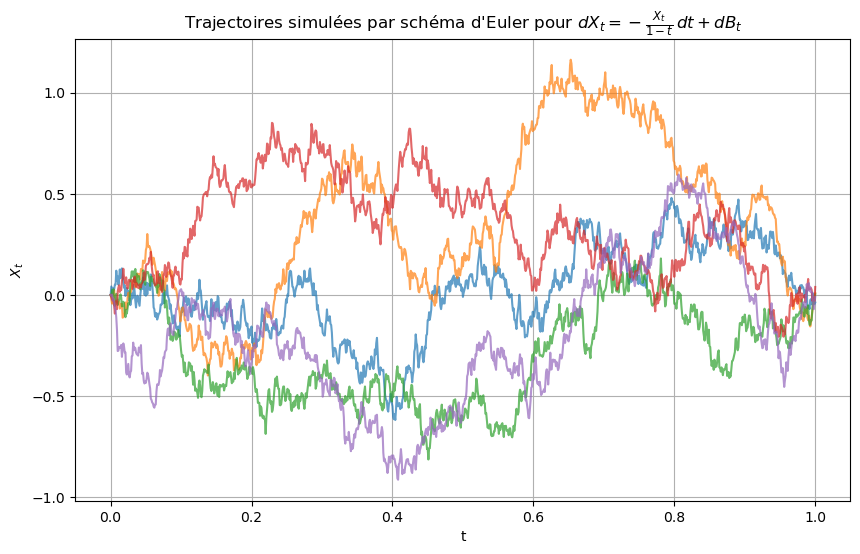

In [20]:
n_points = 1000
n_trajectoires = 5

times, trajectoires = euler_scheme_sde(n_points, n_trajectoires)

plt.figure(figsize=(10, 6))
for traj in trajectoires:
    plt.plot(times, traj, alpha=0.7)
plt.title("Trajectoires simulées par schéma d'Euler pour $dX_t = -\\frac{X_t}{1 - t} \\, dt + dB_t$")
plt.xlabel("t")
plt.ylabel("$X_t$")
plt.grid(True)
plt.show()



**II-3)** Calcul et représentation de la fonction de répartition du maximum du pont brownien, comparaison à celle obtenue par filtrage des trajectoires.

<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
/var/folders/1d/kt59x76x0_1bmktdk50fwr780000gn/T/ipykernel_7640/1208553568.py:22: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mathbb{P}(\max X_t \leq x)$")


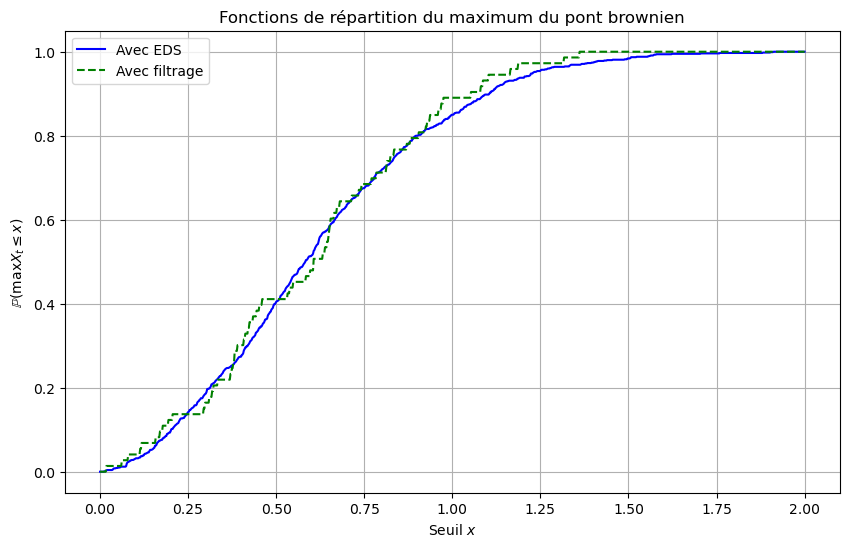

In [21]:

n_trajectoires = 1000
n_points = 1000
liste_seuils = np.linspace(0, 2, n_points)

# Trajectoires simulées par le schéma d'Euler
times, trajectoires_euler = euler_scheme_sde(n_points, n_trajectoires, seed=None)
max_euler = np.max(trajectoires_euler, axis=1)
cdf_euler = cdf_empirique(max_euler, liste_seuils)

# On récupère les trajectoires filtrées de la méthode précédente
epsilon = 0.1
trajectoires_filtrees, _ = brownien_conditionne(epsilon, n_trajectoires, n_points)
max_filtrees = np.max(trajectoires_filtrees, axis=1)
cdf_filtrees = cdf_empirique(max_filtrees, liste_seuils)

# Tracé
plt.figure(figsize=(10, 6))
plt.plot(liste_seuils, cdf_euler, label="Avec EDS", color='blue')
plt.plot(liste_seuils, cdf_filtrees, label="Avec filtrage", color='green', linestyle='--')
plt.title("Fonctions de répartition du maximum du pont brownien")
plt.xlabel("Seuil $x$")
plt.ylabel("$\mathbb{P}(\max X_t \leq x)$")
plt.legend()
plt.grid(True)
plt.show()

Comparaison des deux fonctions de répartition : 
- les deux fonctions ont relativement la même allure, la fonction de répartition obtenue par schéma d'Euler est beaucoup plus lisse même avec seulement 1000 trajectoires. 
- Cela est dû aux nombre de trajectoires utilisées pour tracer les fonctions de répartition : dans le cas de la question 1, sur 1000 trajectoires simulées seulement environ 100 trajectoires sont bien comprises entre $-\epsilon$ et $\epsilon$ et donc peuvent être considérées comme des trajectoires retournant à zéro.
Dans le cas de la question 2 (schéma d'Euler), on créée directement 1000 trajectoires retournant à zéro.
- Pour obtenir un résultat aussi lisse dans le cas de la question 1 tout en étant précis sur ce que l'on appelle "retour à zéro", il faudrait augmenter considérablement le nombre de simulations car plus $\epsilon$ est petit, plus on devra simuler pour obtenir un nombre satisfaisant de trajectoires filtrées.  

## III - Espérance du carré du maximum

Dans cette section on note $U$ le maximum du pont brownien, et on cherche à approcher l'espérance de son carré.

**III-1)** Réalisation d'une simulation par une **méthode de Monte-Carlo**.  

In [22]:
def monte_carlo_eu2(epsilon, n_points, n_trajectoires, seuil_warning=30, verbose=True):
    """
    Compare l'estimation de E[U^2] (carré du maximum du pont brownien) par :
    - Schéma d'Euler (EDS)
    - Méthode de filtrage

    Affiche un warning si le nombre de trajectoires filtrées est faible.
    Lève une exception si aucune trajectoire n'est retenue.

    Returns
    -------
    - eu2_eds : estimation E[U^2] par EDS
    - var_eds : variance de U^2 par EDS
    - eu2_filtrage : estimation E[U^2] par filtrage
    - var_filtrage : variance de U^2 par filtrage
    """

   # Schéma d'Euler (EDS)
    _, trajectoires_eds = euler_scheme_sde(n_points, n_trajectoires)
    max_eds = np.max(trajectoires_eds, axis=1)
    eu2_eds = np.mean(max_eds**2)
    var_eds = np.var(max_eds**2)

    # Méthode de filtrage
    trajectoires_filtrees, _ = brownien_conditionne(epsilon, n_trajectoires, n_points)
    n_ret = len(trajectoires_filtrees)
    if n_ret == 0:
        raise RuntimeError(f"Aucune trajectoire filtrée pour epsilon={epsilon} et n_trajectoires={n_trajectoires}.")
    if n_ret < seuil_warning:
        warnings.warn(f"Seulement {n_ret} trajectoires filtrées sur {n_trajectoires} (epsilon={epsilon}) : estimation peu fiable.", UserWarning)
    
    max_filtrees = np.max(trajectoires_filtrees, axis=1)
    eu2_filtrage = np.mean(max_filtrees**2)
    var_filtrage = np.var(max_filtrees**2)
    if verbose:
        print(f"[EDS]      E[U²] estimé avec {n_trajectoires} trajectoires : {eu2_eds:.4f}, variance : {var_eds:.4f}")
        print(f"[Filtrage] E[U²] estimé avec {n_ret} trajectoires retenues (epsilon={epsilon}) : {eu2_filtrage:.4f}, variance : {var_filtrage:.4f}")

    return eu2_eds, var_eds, eu2_filtrage, var_filtrage, n_ret

n_points = 10000
n_trajectoires = 1000
epsilon = 0.1

monte_carlo_eu2(epsilon, n_points, n_trajectoires)

[EDS]      E[U²] estimé avec 1000 trajectoires : 0.4797, variance : 0.2245
[Filtrage] E[U²] estimé avec 80 trajectoires retenues (epsilon=0.1) : 0.4128, variance : 0.1792


(0.47966374111004223,
 0.22454007851581162,
 0.41275261693814524,
 0.17917190783018255,
 80)

On constate que par méthode de filtrage ou schéma d'Euler, la variance de l'estimateur est relativement élevée. Il convient de chercher à la réduire. 

**III-2)** Implémentation d'une méthode de réduction de variance par **variables antithétiques**

In [42]:
def antithetic(n_points, n_trajectoires, seed=None):
    """
    Estime E[U^2] (U = max du pont brownien) avec variables antithétiques.
    On utilise 2*n_trajectoires en tout.

    Returns
    -------
    float: Estimation de E[U^2]
    float: Variance de l'estimation
    """
    if seed is not None:
        np.random.seed(seed)

    T = 1
    dt = T / n_points
    times = np.linspace(0, T, n_points + 1)
    dB = np.random.normal(0, np.sqrt(dt), size=(n_trajectoires, n_points))
    X1 = np.zeros((n_trajectoires, n_points + 1))
    X2 = np.zeros((n_trajectoires, n_points + 1))
   
    for i in range(1, n_points + 1):
        t = times[i - 1]
        drift1 = -X1[:, i - 1] / (1 - t) * dt
        drift2 = -X2[:, i - 1] / (1 - t) * dt
        X1[:, i] = X1[:, i - 1] + drift1 + dB[:, i - 1]
        X2[:, i] = X2[:, i - 1] + drift2 - dB[:, i - 1]
        
    u1_sq = np.max(X1, axis=1) ** 2
    u2_sq = np.max(X2, axis=1) ** 2
    return (u1_sq + u2_sq) / 2

n_points = 10000
n_trajectoires = 1000
estimation_anti = np.mean(antithetic(n_points, n_trajectoires))
var_anti = np.var(antithetic(n_points, n_trajectoires))
estimation_eds, var_eds, _, _, _ = monte_carlo_eu2(0.1, n_points, n_trajectoires)

print(f"[Antithétique] E[U²] estimé avec {2*n_trajectoires} trajectoires : {estimation_anti:.4f}, variance: {var_anti:.4f})")
print(f"Réduction de variance : {var_eds / var_anti:.2f}x (EDS vs Antithétique)")

[EDS]      E[U²] estimé avec 1000 trajectoires : 0.5020, variance : 0.2656
[Filtrage] E[U²] estimé avec 89 trajectoires retenues (epsilon=0.1) : 0.4916, variance : 0.1459
[Antithétique] E[U²] estimé avec 2000 trajectoires : 0.4844, variance: 0.0664)
Réduction de variance : 4.00x (EDS vs Antithétique)


**III-3)** Établissement de la **valeur exacte** de l'espérance $\mathbb{E}[U^2]$.

On admet que la fonction de répartition du maximum d’un pont brownien est donnée par :
$$
F(u) = \left(1 - e^{-2u^2}\right) \cdot \mathbf{1}_{\mathbb{R}_+}(u), \quad \text{pour } u \in \mathbb{R}.
$$

On calcule alors la densité de $u$, égale à $4u*exp(-2u^2)$.  Par suite la densité de $U^2$ est égale à $u^2$*densité de $u$. On en déduit l'espérance exacte de $U^2$ en intégrant cette dernière 0 et $+\infty$.

On trouve une espérance de $0.5$ (la résolution numérique n'étant pas nécessaire), ce qui correspond à ce vers quoi tend le résultat des deux approximations implémentées jusqu'ici. 

In [24]:
def densite_u(u):
    """Densité du maximum du pont brownien sur [0,1]."""
    return 4 * u * np.exp(-2 * u**2)

# Calcul direct de l'espérance exacte E[U^2]
e_u2, _ = quad(lambda u: u**2 * densite_u(u), 0, np.inf)
print(f"Valeur exacte de E[U^2] : {e_u2:.4f}")

Valeur exacte de E[U^2] : 0.5000


**III-4)** On souhaite désormais implémenter une méthode de réduction de variance par **échantillonnage préférentiel**. 

Comme on connaît désormais la loi de $U$, par changement de variable on constate que  $V = U^2$ suit une loi exponentielle de paramètre $2$. On utilise cela pour simuler Monte-Carlo naïf. 

In [ ]:
# Simulation Monte-Carlo directe avec la loi exacte de V = U^2 ~ Exp(2)
n = 1000
V = np.random.exponential(scale=0.5, size=n)
eu2_exact = np.mean(V)
var_exact = np.var(V, ddof=1)
print(f"Monte Carlo direct (exp(2)) : moyenne = {eu2_exact:.4f}, variance = {var_exact:.4f}")

Monte Carlo direct (loi exacte de U²) : moyenne = 0.4719, variance = 0.2019


La méthode d'échantillonnage préférentiel se basant sur le choix pour la simulation d'une densité auxiliaire "proche" de la densité à intégrer, c'est-à-dire élevée lorsqu'elle est élevée et faible lorsqu'elle est faible, il convient de visualiser la densité à intégrer.

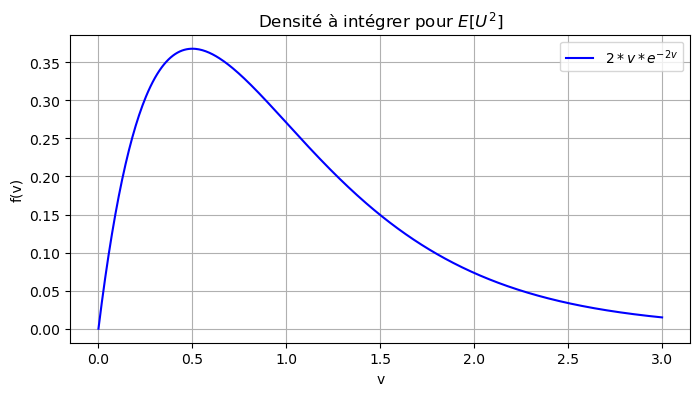

In [47]:
# Visualisation de la densité à intégrer pour choisir g pour importance sampling 
# Pour simplifier on utilise V=U^2

# Densité cible : f_V(v) = 2 * exp(-2v)
def f_v(v):
    return 2 * np.exp(-2 * v)

v = np.linspace(0, 3, 500)
f_exp = f_v(v)
h_int = v*f_exp

plt.figure(figsize=(8, 4))
plt.plot(v, h_int, label=r'$2 * v * e^{-2v}$', color='blue')
plt.title("Densité à intégrer pour $E[U^2]$")
plt.xlabel("v")
plt.ylabel("f(v)")
plt.grid(True)
plt.legend()
plt.show()

On choisit pour la densité auxiliaire la densité de la fonction Gamma de paramètre de forme $2$ et paramètre d'échelle $0.5$. Cette densité est en effet proportionnelle à la densité cible.

In [50]:
n_is = 10000 

# Densité de la loi Gamma(2, 0.5)
def g_v(v):
    return gamma.pdf(v, a=2, scale=0.5)

#Importance sampling
V_samples = gamma.rvs(a=2, scale=0.5, size=n_is)
weights = f_v(V_samples) / g_v(V_samples)
eu2_is = np.mean(V_samples * weights)
var_is = np.var(V_samples * weights, ddof=1)

print(f"Estimation avec échantillonnage préférentiel (Gamma(2, 0.5)) : {eu2_is:.4f}")
print(f"Variance de l'estimateur : {var_is:.4e}")
print(f"Erreur absolue (estimation VS valeur exacte) : {abs(eu2_is - 0.5):.2e}")


Estimation avec échantillonnage préférentiel (Gamma(2, 0.5)) : 0.5000
Variance de l'estimateur : 5.3072e-33
Erreur absolue (estimation VS valeur exacte) : 0.00e+00


La densité auxiliaire est proportionnelle à la densité cible pondérée par $v$, ce qui rend l’estimateur constant et de variance nulle. C'est un cas optimal et exceptionnel, rarement rencontré en pratique. 

On aimerait observer un cas non trivial d'échantillonnage préférentiel, on reproduit alors le code précédent avec différents paramètres pour les lois Gamma. 

In [51]:
# Gamma(1.5, 0.5)
V_samples1 = gamma.rvs(a=1.5, scale=0.5, size=n_is)
g1 = gamma.pdf(V_samples1, a=1.5, scale=0.5)
weights1 = f_v(V_samples1) / g1
eu2_is1 = np.mean(V_samples1 * weights1)
var_is1 = np.var(V_samples1 * weights1, ddof=1)

# Gamma(2, 1)
V_samples2 = gamma.rvs(a=2, scale=1, size=n_is)
g2 = gamma.pdf(V_samples2, a=2, scale=1)
weights2 = f_v(V_samples2) / g2
eu2_is2 = np.mean(V_samples2 * weights2)
var_is2 = np.var(V_samples2 * weights2, ddof=1)

print("Gamma(1.5, 0.5) : estimation =", round(eu2_is1, 4), ", variance =", "{:.3e}".format(var_is1))
print("Gamma(2, 1)   : estimation =", round(eu2_is2, 4), ", variance =", "{:.3e}".format(var_is2))
print(f"Réduction de variance avec Gamma(1.5, 0.5) : {var_eds / var_is1:.2f}x")
print(f"Réduction de variance avec Gamma(2, 1) : {var_eds / var_is2:.2f}x")

Gamma(1.5, 0.5) : estimation = 0.4989 , variance = 4.401e-02
Gamma(2, 1)   : estimation = 0.4969 , variance = 1.937e-01
Réduction de variance avec Gamma(1.5, 0.5) : 6.03x
Réduction de variance avec Gamma(2, 1) : 1.37x


La réduction de variance est bien moindre : nous ne sommes plus dans le cas optimal où la densité auxiliaire est proportionnelle à la densité cible. Avec Gamma(1.5, 0.5) le facteur de réduction reste tout de même plus élevé que celui obtenu par la méthode des variables antithétiques.

Terminons par un tracé des différentes densités, pour la visualisation.

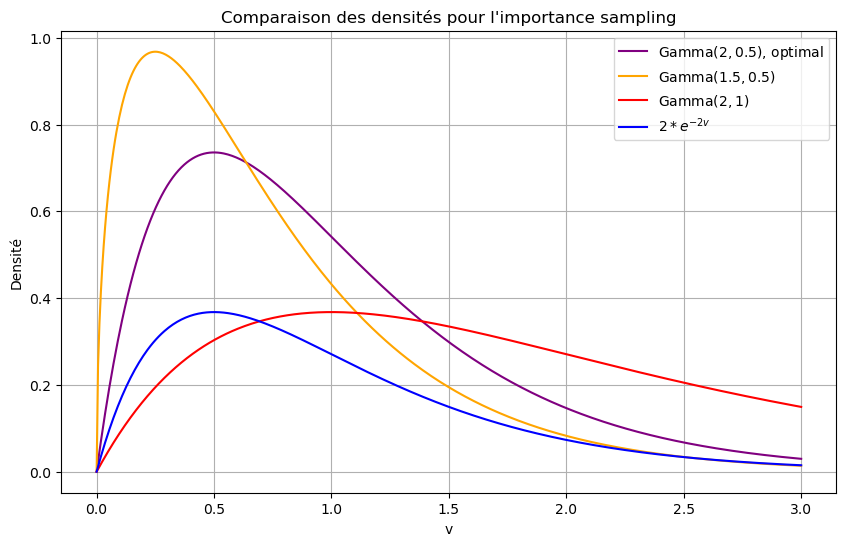

In [53]:
# Tracé comparatif des densités pour importance sampling

v = np.linspace(0, 3, 500)
g_gamma_opt = gamma.pdf(v, a=2, scale=0.5)  # Densité Gamma(2, 0.5)
g_gamma_1_5 = gamma.pdf(v, a=1.5, scale=0.5)  # Densité Gamma(1.5, 0.5)
g_gamma_2_1 = gamma.pdf(v, a=2, scale=1)
h_int = v * f_exp  # Densité à intégrer pour E[U^2]

plt.figure(figsize=(10, 6))
plt.plot(v, g_gamma_opt, label=r'$\mathrm{Gamma}(2, 0.5)$, optimal', color='purple')
plt.plot(v, g_gamma_1_5, label=r'$\mathrm{Gamma}(1.5, 0.5)$', color='orange')
plt.plot(v, g_gamma_2_1, label=r'$\mathrm{Gamma}(2, 1)$', color='red')
plt.plot(v, h_int, label=r'$2 * e^{-2v}$', color='blue')
plt.title("Comparaison des densités pour l'importance sampling")
plt.xlabel("v")
plt.ylabel("Densité")
plt.legend()
plt.grid(True)
plt.show()

Les efficacités relatives des méthode de réduction de variance par échantillonnage préférentiel se retrouvent dans la visualisation des densités: plus la densité auxiliaire est proche de la densité à intégrer, plus la variance sera réduite. 

# IV - Comparaison des méthodes

Nous avons vu plusieurs méthodes d'estimation de l'espérance du carré du maximum, récapitulons leurs principales caractéristiques. 

**IV-1)** Dressage d'un tableau comparant l'estimation et la variance de toutes les méthodes, ainsi que le nombre de trajectoires utilisées, pour $\epsilon = 0.1$.

In [61]:
eu2_eds, var_eds, eu2_filtrage, var_filtrage, n_ret = monte_carlo_eu2(0.1, n_points, n_trajectoires, verbose=False)

df = pd.DataFrame({
    "Méthode": [
        "EDS",
        "Filtrage",
        "Antithétique",
        "Monte-Carlo direct (Exp(2))",
        "Importance sampling optimal (Gamma(2,0.5))",
        "Importance sampling (Gamma(1.5,0.5))",
        "Valeur exacte"
    ],
    "Estimation": [
        eu2_eds,
        eu2_filtrage,
        estimation_anti,
        eu2_exact,
        eu2_is,
        eu2_is1,
        e_u2
    ],
    "Variance": [
        var_eds,
        var_filtrage,
        var_anti,
        var_exact,
        var_is,
        var_is1,
        0.0
    ],
    "Nb trajectoires utilisées": [
        n_trajectoires,
        n_ret,
        2 * n_trajectoires,
        n_trajectoires,
        n_is,
        n_is,
        "-"
    ]
})

print(df.round(3))


                                      Méthode  Estimation  Variance  \
0                                         EDS       0.507     0.257   
1                                    Filtrage       0.466     0.295   
2                                Antithétique       0.484     0.066   
3                 Monte-Carlo direct (Exp(2))       0.472     0.202   
4  Importance sampling optimal (Gamma(2,0.5))       0.500     0.000   
5        Importance sampling (Gamma(1.5,0.5))       0.499     0.044   
6                               Valeur exacte       0.500     0.000   

  Nb trajectoires utilisées  
0                      1000  
1                        75  
2                      2000  
3                      1000  
4                     10000  
5                     10000  
6                         -  


**IV-2)** Comparaison de la convergence, en moyenne et en variance en fonction du nombre de trajectoires. Pour l'échantillonnage préférentiel on étudie ici la version avec Gamma(1.5, 0.5) pour ne pas avoir de résultats triviaux.

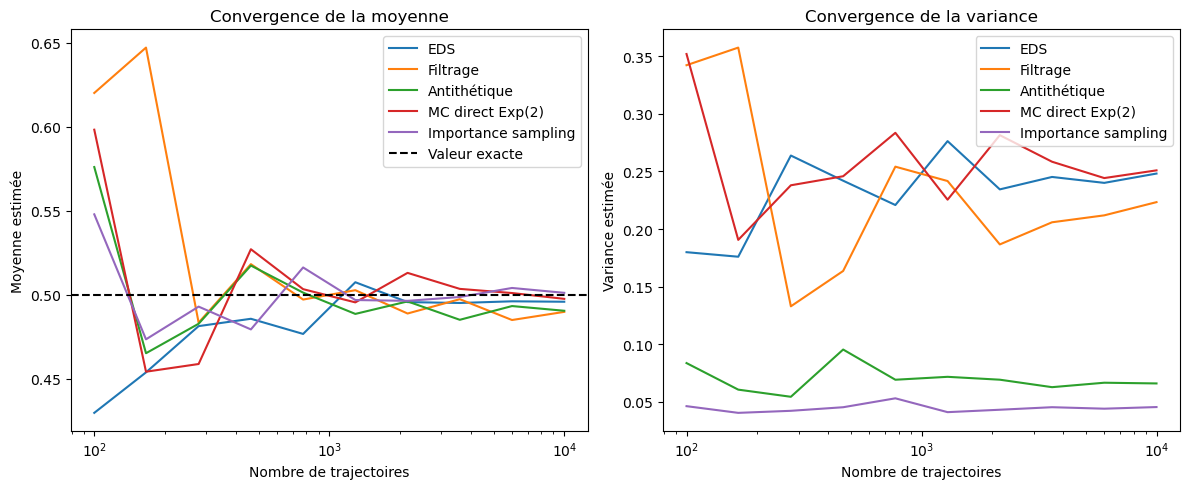

In [62]:

n_list = np.logspace(2, 4, 10, dtype=int)  # de 100 à 10000 trajectoires
eds_means, eds_vars = [], []
filtrage_means, filtrage_vars = [], []
anti_means, anti_vars = [], []
mc_means, mc_vars = [], []
is_means, is_vars = [], []

for n in n_list:
    # EDS
    _, traj_eds = euler_scheme_sde(n_points, n)
    max_eds = np.max(traj_eds, axis=1)
    eds_means.append(np.mean(max_eds**2))
    eds_vars.append(np.var(max_eds**2))
    # Filtrage
    traj_filtrees, _ = brownien_conditionne(epsilon, n, n_points)
    if len(traj_filtrees) > 0:
        max_filtrees = np.max(traj_filtrees, axis=1)
        filtrage_means.append(np.mean(max_filtrees**2))
        filtrage_vars.append(np.var(max_filtrees**2))
    else:
        filtrage_means.append(np.nan)
        filtrage_vars.append(np.nan)
    # Antithétique
    anti_vals = antithetic(n_points, n)
    anti_means.append(np.mean(anti_vals))
    anti_vars.append(np.var(anti_vals))
    # MC direct
    V = np.random.exponential(scale=0.5, size=n)
    mc_means.append(np.mean(V))
    mc_vars.append(np.var(V))
    # Importance sampling (Gamma(1.5,0.5))
    V_samples_is = gamma.rvs(a=1.5, scale=0.5, size=n)
    g_is = gamma.pdf(V_samples_is, a=1.5, scale=0.5)
    weights_is = f_v(V_samples_is) / g_is
    is_means.append(np.mean(V_samples_is * weights_is))
    is_vars.append(np.var(V_samples_is * weights_is, ddof=1))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(n_list, eds_means, label="EDS")
plt.plot(n_list, filtrage_means, label="Filtrage")
plt.plot(n_list, anti_means, label="Antithétique")
plt.plot(n_list, mc_means, label="MC direct Exp(2)")
plt.plot(n_list, is_means, label="Importance sampling")
plt.axhline(e_u2, color='black', linestyle='--', label="Valeur exacte")
plt.xscale('log')
plt.xlabel("Nombre de trajectoires")
plt.ylabel("Moyenne estimée")
plt.title("Convergence de la moyenne")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(n_list, eds_vars, label="EDS")
plt.plot(n_list, filtrage_vars, label="Filtrage")
plt.plot(n_list, anti_vars, label="Antithétique")
plt.plot(n_list, mc_vars, label="MC direct Exp(2)")
plt.plot(n_list, is_vars, label="Importance sampling")
plt.xscale('log')
plt.xlabel("Nombre de trajectoires")
plt.ylabel("Variance estimée")
plt.title("Convergence de la variance")
plt.legend()
plt.tight_layout()
plt.show()

Interprétations du tracé des convergences : 
- Toutes les méthodes convergent vers la valeur exacte $0.5$ lorsque le nombre de trajectoires augmente, ce qui valide la justesse des estimateurs
- Monte-Carlo direct (Exp(2)) converge rapidement et sans biais en moyenne et en variance, car on simule directement la loi exacte
- EDS (schéma d'Euler), méthode antithétique et échantillonnage préférentiel convergent aussi en moyenne, mais peuvent présenter un léger biais pour un petit nombre de trajectoires, qui disparaît avec $n$. En revanche en variance on retrouve bien le comportement observé plus haut : les deux méthodes de réduction de variance apportent une amélioration significative par rapport à EDS, surtout pour un nombre faible de trajectoires.
- Le filtrage est plus lent à converger, et peut donner une variance très élevée même avec beaucoup de trajectoires. Cette méthode est donc peu efficace, il faut beaucoup de simulations pour obtenir une estimation fiable.


**IV-3)** Comparaison des distributions et des temps de calcul

On cherche à visualiser la dispersion des estimateurs obtenus par les différentes méthodes, sauf par la méthode d'échantillonnage préférentiel car la variance est nulle. On ajoute aussi une comparaison des temps de calcul par méthode, pour ne pas répéter l'appel aux fonctions à chaque comparaison.

Temps de calcul pour 2000 trajectoires :
EDS                : 0.884 s
Filtrage           : 0.699 s
Antithétique       : 1.392 s
MC direct Exp(2)   : 0.000 s
Importance sampling: 0.001 s


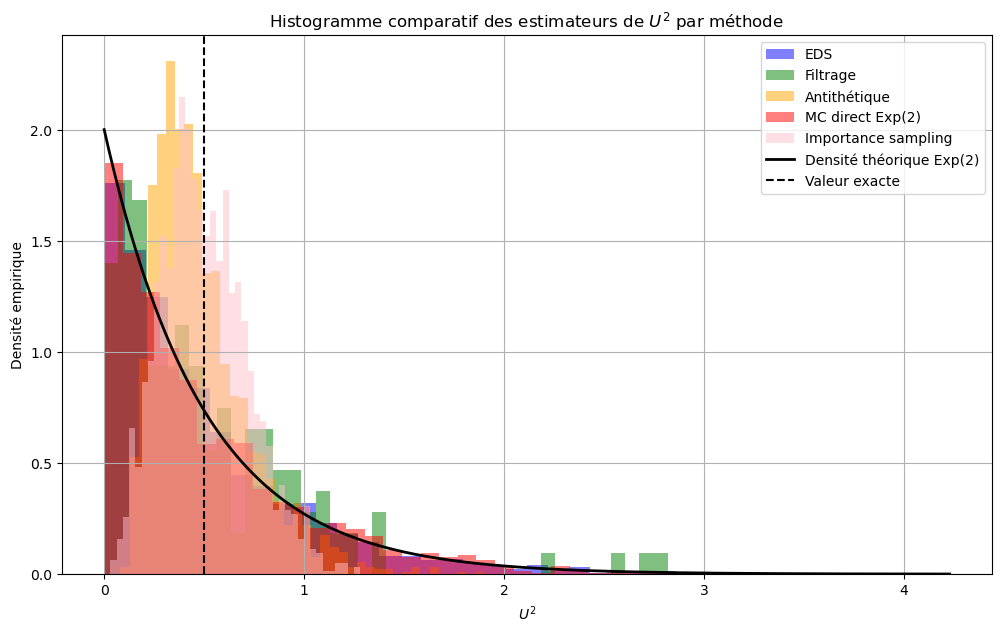

In [65]:
n_test = 2000

# EDS
start = time.time()
_, trajectoires_eds = euler_scheme_sde(n_points, n_test)
max_eds = np.max(trajectoires_eds, axis=1)
eds_time = time.time() - start

# Filtrage
start = time.time()
trajectoires_filtrees, _ = brownien_conditionne(epsilon, n_test, n_points)
if len(trajectoires_filtrees) > 0:
    max_filtrees = np.max(trajectoires_filtrees, axis=1)
else:
    max_filtrees = np.array([])
filtrage_time = time.time() - start

# Antithétique
start = time.time()
anti_vals = antithetic(n_points, n_test)
anti_time = time.time() - start

# Monte-Carlo direct (Exp(2))
start = time.time()
V = np.random.exponential(scale=0.5, size=n_test)
mc_time = time.time() - start

# Importance sampling 
start = time.time()
V_samples = gamma.rvs(a=1.5, scale=0.5, size=n_test)
g_is = gamma.pdf(V_samples, a=1.5, scale=0.5)
weights_is = f_v(V_samples) / g_is
is_vals = V_samples * weights_is
is_time = time.time() - start

# Affichage des temps de calcul
print("Temps de calcul pour", n_test, "trajectoires :")
print(f"EDS                : {eds_time:.3f} s")
print(f"Filtrage           : {filtrage_time:.3f} s")
print(f"Antithétique       : {anti_time:.3f} s")
print(f"MC direct Exp(2)   : {mc_time:.3f} s")
print(f"Importance sampling: {is_time:.3f} s")

# Tracé des histogrammes 
plt.figure(figsize=(12, 7))
plt.hist(max_eds**2, bins=40, alpha=0.5, label="EDS", color='blue', density=True)
if len(max_filtrees) > 0:
    plt.hist(max_filtrees**2, bins=40, alpha=0.5, label="Filtrage", color='green', density=True)
plt.hist(anti_vals, bins=40, alpha=0.5, label="Antithétique", color='orange', density=True)
plt.hist(V, bins=40, alpha=0.5, label="MC direct Exp(2)", color='red', density=True)
plt.hist(is_vals, bins=40, alpha=0.5, label="Importance sampling", color='pink', density=True)

# Tracé de la densité théorique Exp(2)
x = np.linspace(0, np.max(max_eds**2), 500)
plt.plot(x, 2 * np.exp(-2 * x), 'k-', lw=2, label="Densité théorique Exp(2)")

plt.axvline(e_u2, color='black', linestyle='--', label="Valeur exacte")
plt.xlabel("$U^2$")
plt.ylabel("Densité empirique")
plt.title("Histogramme comparatif des estimateurs de $U^2$ par méthode")
plt.legend()
plt.grid(True)
plt.show()

Les histogrammes des différentes méthodes recouvrent bien pour la plupart la courbe de la densité théorique, nos résultats sont valides. La méthode de filtrage donne cependant un histogramme plus bruité et irrégulier car peu de trajectoires sont retenues. Les deux méthodes de réduction de variance affichent un histogramme différent, les pics sont plus hauts et davantage centrés sur la valeur exacte ce qui illustre bien la réduction de variance. 

# V - Application au pricing d'options

Le pont brownien, ainsi que la loi de son maximum possède de nombreuses applications en finance, notamment dans le domaine du pricing d’options path-dépendantes. La connaissance de la loi du maximum permet d’étudier les probabilités d’atteinte de certains seuils, centrales pour la définition des options barrières.
Nous allons donc dans cette section procéder au pricing d'une option **barrière knock-in de type call sur le maximum**.

#### Données 
- Processus sous-jacent : pont brownien simulé via le schéma d'Euler
- Nombre de trajectoires simulées : `n_trajectoires = 10000`
- Nombre de pas de temps par trajectoire : `n_points = 1000`
- Barrière à surveiller : $B$
- Strike de l'option : $K$

#### Hypothèses
- Le pont brownien $X_t$ satisfait $X_0 = X_1 = 0$
- Les trajectoires sont simulées sur $[0,1]$ par schéma d'Euler, sans méthode de réduction de variance dans un premier temps
- Le maximum est atteint entre $t=0$ et $t=1$ : $\max_{t \in [0,1]} X_t$

#### Payoff considéré
On ne considère pas le payoff classique $(X_1 - K)^+$ car $X_1 = 0$ pour un pont brownien.  
On utilise plutôt un payoff sur le **maximum** conditionné à un knock-in :

$$
\text{payoff} = \max(\max_{t \in [0,1]} X_t - K,\ 0) \cdot \mathbf{1}_{\left\{ \max_{t \in [0,1]} X_t \geq B \right\}}
$$

C’est-à-dire que si la barrière $B$ est franchie à un moment donné on paie le call sur le maximum, sinon le payoff est nul. 




In [67]:
def call_knock_in_max(trajectoires, K, B):
    """
    Calcule le payoff du call knock-in sur le maximum du pont brownien.
    """
    max_vals = np.max(trajectoires, axis=1)
    indicatrice = (max_vals >= B).astype(float)
    payoff = np.maximum(max_vals - K, 0) * indicatrice
    return payoff

# Paramètres
n_trajectoires = 10000
n_points = 1000
K = 0.4       # Strike
B = 0.5       # Barrière
seed = 42

# Appel de la fonction implémentant le schéma d'Euler pour générer les trajectoires
times, trajectoires = euler_scheme_sde(n_points=n_points, n_trajectoires=n_trajectoires, seed=seed)

# Pricing 
payoffs = call_knock_in_max(trajectoires, K=K, B=B)
prix = np.mean(payoffs)
std = np.std(payoffs)
ic_95 = 1.96 * std / np.sqrt(n_trajectoires)

print(f"Prix estimé du call knock-in sur le maximum : {prix:.4f} ± {ic_95:.4f} (IC 95%)")

Prix estimé du call knock-in sur le maximum : 0.2457 ± 0.0055 (IC 95%)


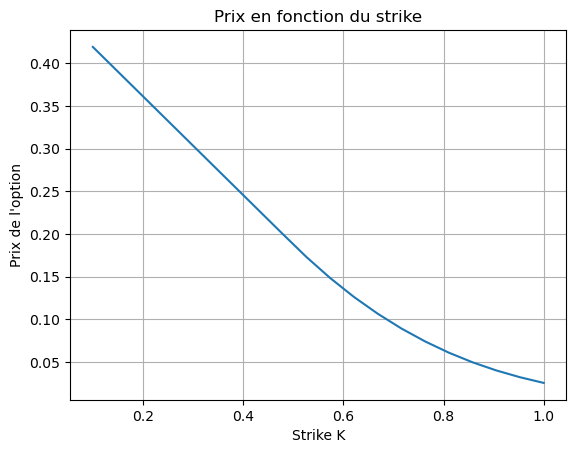

In [68]:
K_vals = np.linspace(0.1, 1.0, 20)
prix_vs_K = [np.mean(call_knock_in_max(trajectoires, K=k, B=B)) for k in K_vals]

plt.plot(K_vals, prix_vs_K)
plt.xlabel("Strike K")
plt.ylabel("Prix de l'option")
plt.title("Prix en fonction du strike")
plt.grid()
plt.show()

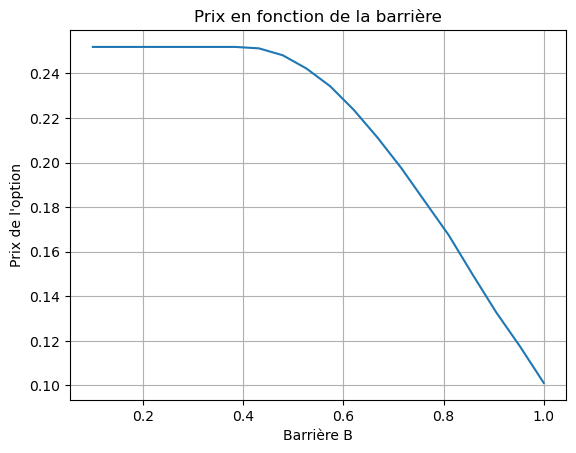

In [69]:
B_vals = np.linspace(0.1, 1.0, 20)
prix_vs_B = [np.mean(call_knock_in_max(trajectoires, K=K, B=b)) for b in B_vals]

plt.plot(B_vals, prix_vs_B)
plt.xlabel("Barrière B")
plt.ylabel("Prix de l'option")
plt.title("Prix en fonction de la barrière")
plt.grid()
plt.show()

Cette rapide analyse de sensibilité nous montre des comportements attendus : une décroissance du prix avec le strike, et un seuil critique de la barrière à partir duquel le prix chute drastiquement (environ vers B = 0.5). 

En effet, nous avons vu que le carré du maximum suit une loi exponentielle de paramètre 2. 
La fonction de répartition du maximum $U = \max_{t \in [0,1]} B_t$ est donc liée à celle de $U^2$ :

$P(U \leq B) = P(U^2 \leq B^2) = 1 - e^{-2B^2}$

La probabilité que le maximum dépasse la barrière est donc : $P(U \geq B) = e^{-2B^2}$

Cette probabilité décroît exponentiellement en $B^2$, c'est pourquoi la décroissance du prix de l’option knock-in n'est pas linéaire en le prix de la barrière. 

### Prochaines étapes

Afin de poursuivre ce travail, nous pourrions dans un premier temps étudier l'impact d'une méthode de réduction de variance sur la précision de notre pricing. 

Avec plus de recul, nous pourrions étudier d'autres types d'options exotiques, comme des options à barrière continue par exemple.   

Il convient également d'étendre à des modèles plus réalistes, en simulant un actif sous-jacent et non un simple pont brownien, et en ajoutant dérive et volatilité comme dans le modèle de Black-Scholes.  